# Importing libraries and data


## Libraries


In [2]:
import itk
from vtk_viewer import render

import matplotlib.pyplot as plt

## Data Loading


In [3]:
scan1_path = "data/case6_gre1.nrrd"
scan2_path = "data/case6_gre2.nrrd"

scan1 = itk.imread(scan1_path, itk.F)
scan2 = itk.imread(scan2_path, itk.F)

print("scan1: ", scan1.shape)
print("scan2: ", scan2.shape)

vtk_scan1 = itk.vtk_image_from_image(scan1)
vtk_scan2 = itk.vtk_image_from_image(scan2)


scan1:  (176, 256, 256)
scan2:  (176, 256, 256)


## Data Visualization


In [4]:
def show_images(images, index, titles):

    gridX = 1
    gridY = len(images)

    fig = plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = fig.add_subplot(gridX, gridY, i + 1)
        ax.imshow(images[i][index, :, :])
        ax.set_title(titles[i] + " " + str(index))
        ax.axis("off")

    plt.show()


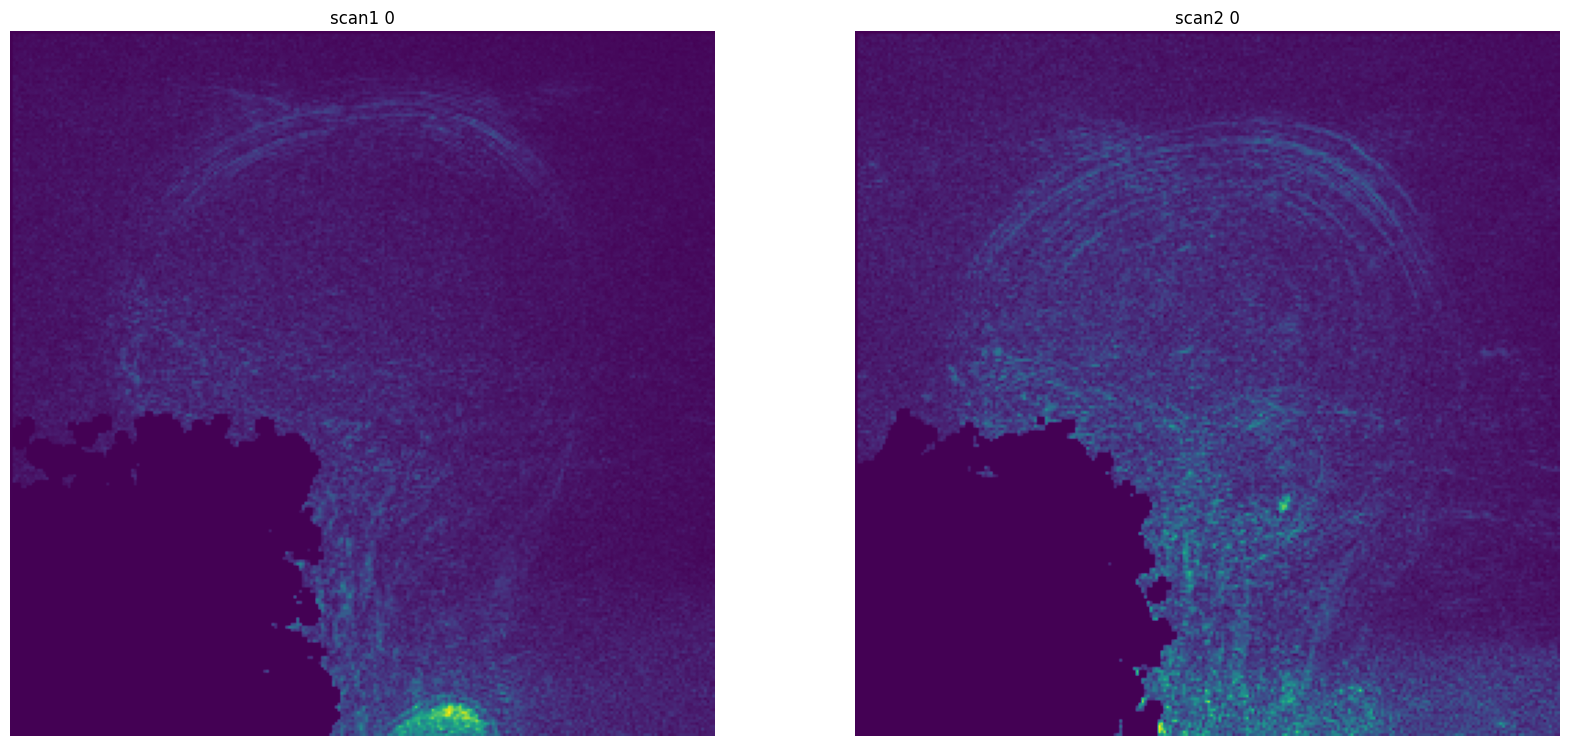

In [5]:
show_images([scan1, scan2], 0, ["scan1", "scan2"])


In [6]:
render([scan1, scan2], ["Scan 1", "Scan 2"])

# Image Repositioning


## Registration

In [7]:
def register(fixed_image, moving_image):

    dimension = fixed_image.GetImageDimension()
    FixedImageType = type(fixed_image)
    MovingImageType = type(moving_image)

    # create registration object
    registration_method = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType].New(
    )

    # set registration method
    registration_method.SetFixedImage(fixed_image)
    registration_method.SetMovingImage(moving_image)

    # set initial transform
    TransformType = itk.TranslationTransform[itk.D, dimension]
    initial_transform = TransformType.New()
    registration_method.SetInitialTransform(initial_transform)

    # set metric
    metric = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType].New(
    )
    registration_method.SetMetric(metric)

    # set optimizer
    optimizer = itk.RegularStepGradientDescentOptimizerv4[itk.D].New()
    optimizer.SetLearningRate(4)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(200)
    registration_method.SetOptimizer(optimizer)

    # set interpolator
    fixed_interpolation = itk.LinearInterpolateImageFunction[FixedImageType, itk.D].New(
    )
    metric.SetFixedInterpolator(fixed_interpolation)

    moving_initial_transform = TransformType.New()
    initial_parameters = moving_initial_transform.GetParameters()
    initial_parameters[0] = 0
    initial_parameters[1] = 0
    initial_parameters[2] = 0
    moving_initial_transform.SetParameters(initial_parameters)

    # set the scales
    scale_parameters = moving_initial_transform.GetParameters()
    scale_parameters[0] = 1000
    scale_parameters[1] = 1
    scale_parameters[2] = 1
    optimizer.SetScales(scale_parameters)

    registration_method.SetMovingInitialTransform(moving_initial_transform)

    identity_transform = TransformType.New()
    identity_transform.SetIdentity()
    registration_method.SetFixedInitialTransform(identity_transform)

    registration_method.SetNumberOfLevels(1)
    # registration_method.SetSmoothingSigmasPerLevel([0])
    # registration_method.SetShrinkFactorsPerLevel([1])

    # perform registration
    registration_method.Update()

    # get transform
    final_transform = registration_method.GetTransform()
    final_parameters = final_transform.GetParameters()
    translation_along_x = final_parameters.GetElement(0)
    translation_along_y = final_parameters.GetElement(1)

    number_of_iterations = optimizer.GetCurrentIteration()

    best_value = optimizer.GetValue()

    print("Result =")
    print("Translation X = " + str(translation_along_x))
    print("Translation Y = " + str(translation_along_y))
    print("Iterations    = " + str(number_of_iterations))
    print("Metric value  = " + str(best_value))

    CompositeTransformType = itk.CompositeTransform[itk.D, dimension]
    output_composite_transform = CompositeTransformType.New()
    output_composite_transform.AddTransform(moving_initial_transform)
    output_composite_transform.AddTransform(
        registration_method.GetModifiableTransform())

    return output_composite_transform


In [8]:
final_transform = register(scan1, scan2)
print(final_transform)


Result =
Translation X = -0.0448365291014926
Translation Y = -3.729695789495754
Iterations    = 32
Metric value  = -0.8655802792385209
CompositeTransform (0x2bfa37b30)
  RTTI typeinfo:   itk::CompositeTransform<double, 3u>
  Reference Count: 1
  Modified Time: 2122
  Debug: Off
  Object Name: 
  Observers: 
    none
  Transforms in queue, from begin to end:
  >>>>>>>>>
  TranslationTransform (0x28268d9d0)
    RTTI typeinfo:   itk::TranslationTransform<double, 3u>
    Reference Count: 1
    Modified Time: 1275
    Debug: Off
    Object Name: 
    Observers: 
      none
    Offset: [0, 0, 0]
  >>>>>>>>>
  TranslationTransform (0x282688240)
    RTTI typeinfo:   itk::TranslationTransform<double, 3u>
    Reference Count: 1
    Modified Time: 2116
    Debug: Off
    Object Name: 
    Observers: 
      none
    Offset: [-0.0448365, -3.7297, -59.8959]
  End of MultiTransform.
<<<<<<<<<<
  TransformsToOptimizeFlags, begin() to end(): 
    1 1 
  TransformsToOptimize in queue, from begin to end:

## Apply Transformation

In [9]:
def apply_transform(transform, ref, image):

    resample_filter = itk.ResampleImageFilter.New(image)
    resample_filter.SetTransform(transform)
    resample_filter.SetUseReferenceImage(True)
    resample_filter.SetReferenceImage(ref)

    resample_filter.SetDefaultPixelValue(100)
    resample_filter.Update()
    return resample_filter.GetOutput()


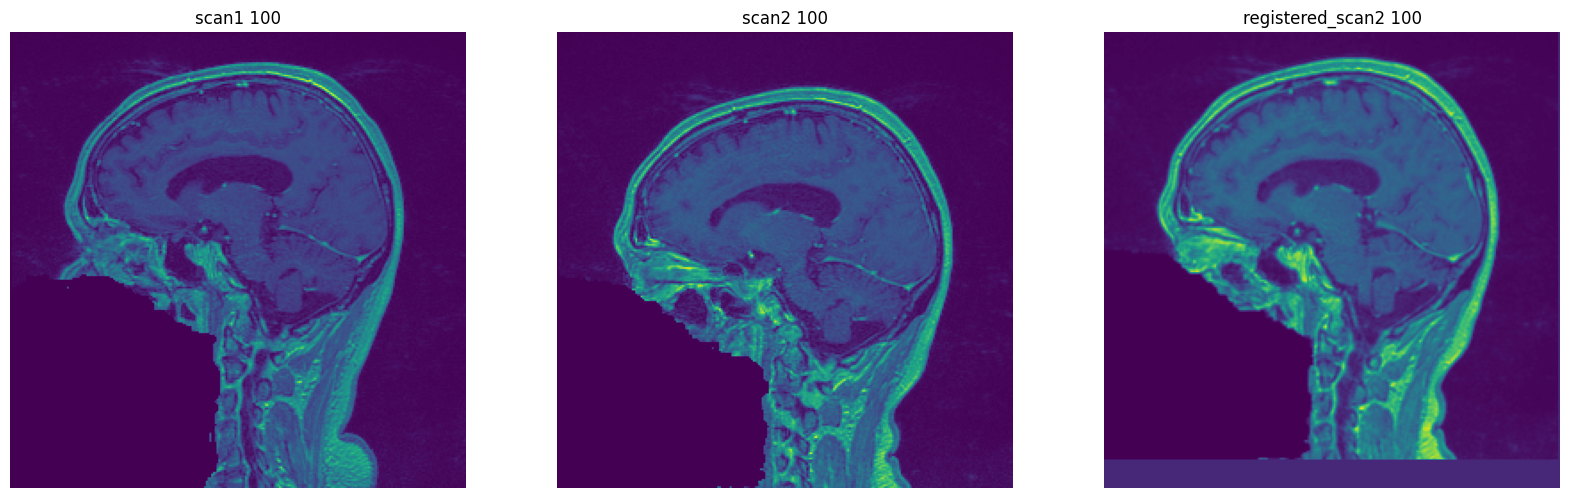

In [10]:
registered_scan2 = apply_transform(final_transform, scan1, scan2)

show_images([scan1, scan2, registered_scan2], 100,
            ["scan1", "scan2", "registered_scan2"])


In [11]:
render([scan1, scan2, registered_scan2],  ["Scan 1", "Scan 2", "image recalée"])

# Segmentation

In [12]:
def segment_tumor(image, seed, radius):

    # Smoothing using anisotropic diffusion filter
    smoothing_filter = itk.GradientAnisotropicDiffusionImageFilter.New(image)
    smoothing_filter.SetTimeStep(0.125)
    smoothing_filter.SetNumberOfIterations(10)
    smoothing_filter.SetConductanceParameter(1.0)
    smoothing_filter.Update()
    smoothed_image = smoothing_filter.GetOutput()

    # Normalize the image
    normalize_filter = itk.NormalizeImageFilter.New(smoothed_image)
    normalize_filter.Update()
    normalized_image = normalize_filter.GetOutput()

    confidence_connected = itk.ConfidenceConnectedImageFilter.New(normalized_image)
    confidence_connected.SetMultiplier(2.5)
    confidence_connected.SetNumberOfIterations(12)
    confidence_connected.SetInitialNeighborhoodRadius(radius)
    confidence_connected.SetReplaceValue(255)

    confidence_connected.SetSeed(tuple(int(i) for i in seed))

    confidence_connected.Update()

    segmented_scan = confidence_connected.GetOutput()
    caster = itk.CastImageFilter[itk.Image.SS3, itk.Image.F3].New()
    caster.SetInput(segmented_scan)
    caster.Update()
    segmented_scan = caster.GetOutput()

    return segmented_scan

In [13]:
seed = [90, 69, 50]
radius = 2
segmented_scan1 = segment_tumor(scan1, seed, radius)
segmented_scan2 = segment_tumor(registered_scan2, seed, radius)

final_scan_1 = itk.add_image_filter(scan1, segmented_scan1)
final_scan_2 = itk.add_image_filter(registered_scan2, segmented_scan2)
evolution = itk.add_image_filter(segmented_scan2, segmented_scan1)

GradientAnisotropicDiffusionImageFilter (0x2c1d65b90): Anisotropic diffusion unstable time step: 0.125
Stable time step for this image must be smaller than 0.0625

GradientAnisotropicDiffusionImageFilter (0x2c1d65b90): Anisotropic diffusion unstable time step: 0.125
Stable time step for this image must be smaller than 0.0625

GradientAnisotropicDiffusionImageFilter (0x2c1d65b90): Anisotropic diffusion unstable time step: 0.125
Stable time step for this image must be smaller than 0.0625

GradientAnisotropicDiffusionImageFilter (0x2c1d65b90): Anisotropic diffusion unstable time step: 0.125
Stable time step for this image must be smaller than 0.0625

GradientAnisotropicDiffusionImageFilter (0x2c1d65b90): Anisotropic diffusion unstable time step: 0.125
Stable time step for this image must be smaller than 0.0625

GradientAnisotropicDiffusionImageFilter (0x2c1d65b90): Anisotropic diffusion unstable time step: 0.125
Stable time step for this image must be smaller than 0.0625

GradientAnisotro

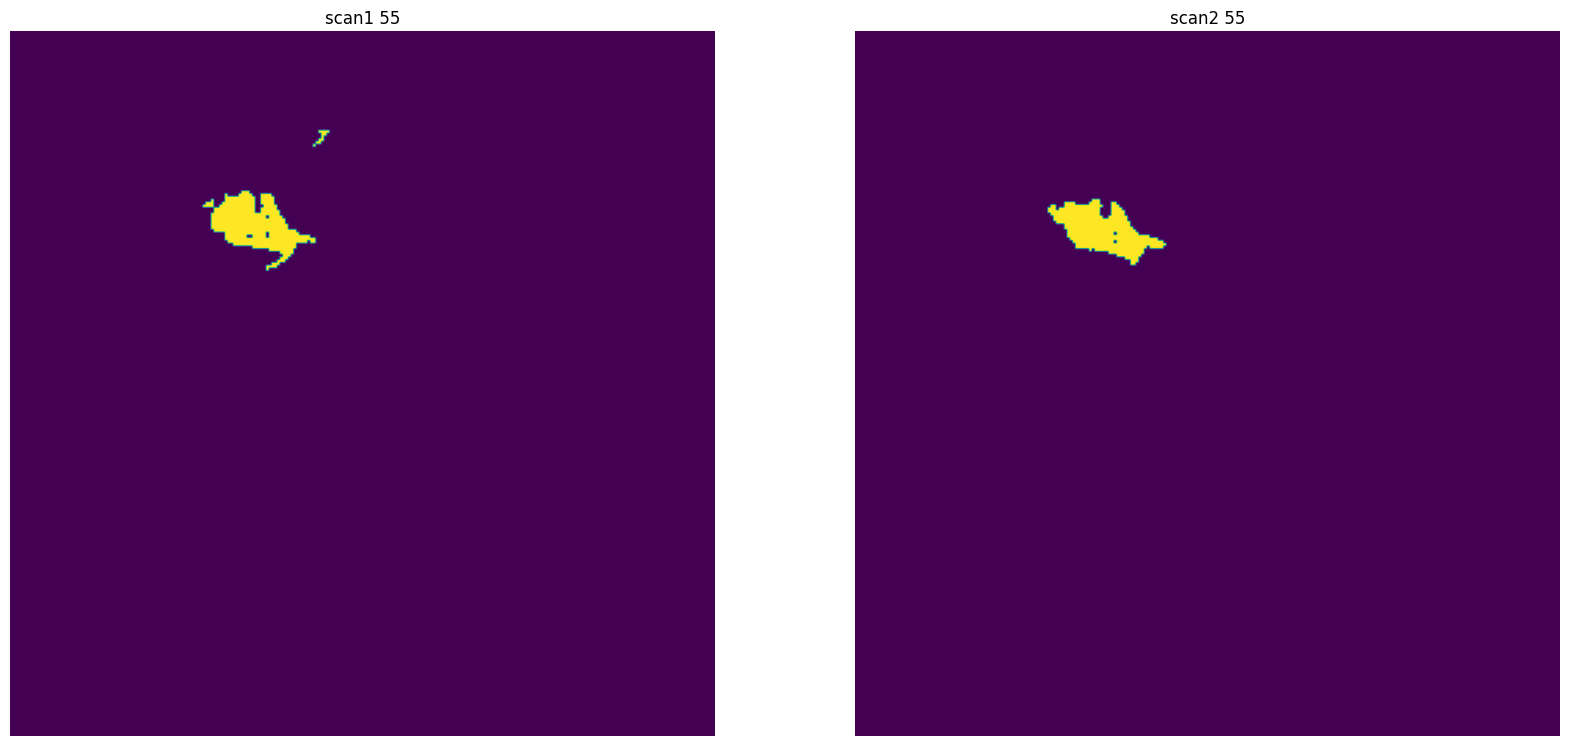

In [14]:
show_images([segmented_scan1, segmented_scan2], 55, ["scan1", "scan2"])

In [15]:
render( [scan1, registered_scan2, final_scan_1, final_scan_2, evolution], ["Scan 1", "Scan 2", "Segmented Scan 1", "Segmented Scan 2", "Evolution"])

In [16]:
#save segmented scan
itk.imwrite(segmented_scan1, "segmented_scan1.nii")

# Analysis

In [55]:
def get_voxel_size(image):

    image_spacing = image.GetSpacing()
    voxel_size = image_spacing[0] * image_spacing[1] * image_spacing[2]

    return voxel_size


def get_volume(image):

    voxel_size = get_voxel_size(image)
    image_array = itk.array_from_image(image)
    return (image_array > 0).sum() * voxel_size


volume1 = get_volume(segmented_scan1)
volume2 = get_volume(segmented_scan2)

print(f"Volume 1: {volume1}mm3")
print(f"Volume 2: {volume2}mm3")
print(f"Volume difference: {volume2 - volume1}mm3")


Volume 1: 9664.0mm3
Volume 2: 9224.0mm3
Volume difference: -440.0mm3
